In [1]:
import pandas as pd
import numpy as np

In [2]:
base_path = "data"
train = pd.read_csv(f'{base_path}/train.csv.zip', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv.zip', index_col="ID")
submission = pd.read_csv(f'{base_path}/sample_submission.csv.zip', index_col="ID")

In [3]:
categorical_feature = train.select_dtypes(include="object").columns
train[categorical_feature] = train[categorical_feature].astype("category")
test[categorical_feature] = test[categorical_feature].astype("category")

In [4]:
X, y = train.drop(columns="y"), train["y"]
X.shape, y.shape

((4209, 376), (4209,))

In [5]:
# train_test_split을 이용해 X, y 값을 X_train, X_valid, y_train, y_valid 으로 나눠줍니다.
# Hold-out-valiation을 위해 train, valid 세트로 나누기
# test_size=0.1 => 이름은 test지만 train으로 나눠주었기 때문에 valid 사이즈를 지정한 것입니다.
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3998, 376), (211, 376), (3998,), (211,))

In [6]:
X_test = test

In [7]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[categorical_feature] = oe.fit_transform(X_train[categorical_feature])
X_valid[categorical_feature] = oe.transform(X_valid[categorical_feature])
X_test[categorical_feature] = oe.transform(X_test[categorical_feature])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


# PyTorch 모델을 위한 데이터 변환
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_valid = torch.FloatTensor(X_valid.values)
y_valid = torch.FloatTensor(y_valid.values.reshape(-1, 1))
X_test = torch.FloatTensor(X_test.values)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([3998, 376]),
 torch.Size([3998, 1]),
 torch.Size([211, 376]),
 torch.Size([211, 1]))

<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

* [예제로 배우는 파이토치(PyTorch) — 파이토치 한국어 튜토리얼 (PyTorch tutorials in Korean)](https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html)
* [Linear — PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)


* super(MultivariateLinearRegression, self).__init__()
    * 파이썬에서 다중 상속(multiple inheritance)을 사용할 때, 부모 클래스의 초기화 메서드를 호출합니다. 여기서는 파이토치의 nn.Module 클래스를 상속받는 MultivariateLinearRegression 클래스를 정의하고 있습니다. nn.Module 클래스는 파이토치 모델을 정의할 때 사용하는 기본 클래스이며, 초기화 메서드(init)를 포함하고 있습니다. 따라서 MultivariateLinearRegression 클래스에서는 nn.Module 클래스의 초기화 메서드를 호출해야 합니다. 그런데, 파이썬에서 다중 상속을 사용할 경우, 여러 개의 부모 클래스 중에서 어떤 클래스의 초기화 메서드를 호출해야 하는지가 모호해질 수 있습니다. 이를 해결하기 위해 파이썬에서는 super() 함수를 제공합니다. super() 함수는 현재 클래스(MultivariateLinearRegression)의 다음 부모 클래스(nn.Module)를 찾아서, 해당 클래스의 메서드(init)를 호출합니다. 이때, super() 함수에 첫 번째 인자로 현재 클래스(self)와 두 번째 인자로 self를 전달합니다. 이를 통해 현재 클래스(MultivariateLinearRegression)가 nn.Module 클래스를 상속받은 것임을 알리고, nn.Module 클래스의 초기화 메서드를 호출할 수 있게 됩니다. MultivariateLinearRegression 클래스의 다음 부모 클래스(nn.Module)의 초기화 메서드를 호출합니다.
    
    
* self.linear = nn.Linear(input_size, output_size)
    * self.linear은 인스턴스 변수(instance variable)입니다. 인스턴스 변수란, 클래스에서 생성된 객체(instance)의 속성(attribute)으로, 객체가 생성될 때마다 각각의 객체마다 고유한 값을 가지게 됩니다. self.linear은 MultivariateLinearRegression 클래스의 생성자(constructor)인 __init__ 메서드에서 초기화되었으며, 이후 클래스 내부의 다른 메서드에서도 사용될 수 있습니다. 따라서, self.linear는 MultivariateLinearRegression 클래스의 인스턴스(instance)의 속성(attribute)으로, 입력 특성과 출력 특성 사이의 선형 변환을 수행하는 신경망 계층(linear layer)을 나타냅니다.

In [9]:
# Multivariate Linear Regression 모델 구현
class MultivariateLinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultivariateLinearRegression, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
        )
        
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x
    

class R2ScoreLoss(nn.Module):
    def __init__(self):
        super(R2ScoreLoss, self).__init__()

    def forward(self, y_pred, y_true):
        residual = y_true - y_pred
        total = y_true - torch.mean(y_true)
        r2_score = 1 - torch.sum(residual**2) / torch.sum(total**2)
        return r2_score
    
    
    
# 모델 인스턴스 생성
model = MultivariateLinearRegression(input_size=X_train.shape[1], output_size=1)

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## train

In [10]:
# 모델 학습하기
num_epochs = 2000

criterion_loss = []
for epoch in range(num_epochs):
    # 순전파 계산
    y_pred = model(X_train)
    
    # 손실 계산
    loss = criterion(y_pred, y_train)

    # 역전파 계산 및 가중치 갱신
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    criterion_loss.append(loss.item())
    # 로그 출력
    if (epoch+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}]')

# 테스트 데이터에 대한 예측 결과 출력
with torch.no_grad():
    y_pred_valid = model(X_valid)
    test_loss = criterion(y_pred_valid, y_valid).item()
    print(f'Test Loss: {test_loss:.4f}')

Epoch [200/2000], Loss: 71.8393]
Epoch [400/2000], Loss: 62.6048]
Epoch [600/2000], Loss: 58.0403]
Epoch [800/2000], Loss: 54.0885]
Epoch [1000/2000], Loss: 50.1410]
Epoch [1200/2000], Loss: 46.7150]
Epoch [1400/2000], Loss: 43.4353]
Epoch [1600/2000], Loss: 40.4434]
Epoch [1800/2000], Loss: 37.9213]
Epoch [2000/2000], Loss: 35.7564]
Test Loss: 82.3404


In [11]:
y_valid.shape, y_pred_valid.shape

(torch.Size([211, 1]), torch.Size([211, 1]))

<Axes: >

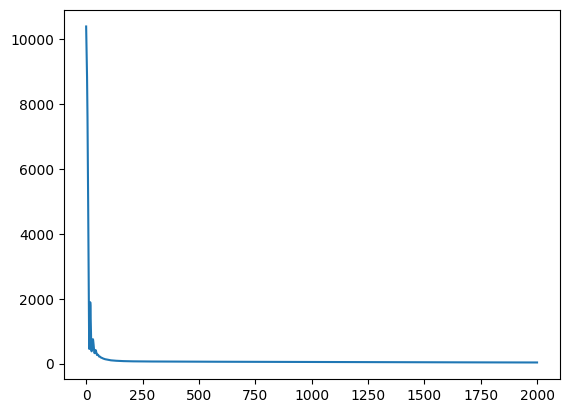

In [15]:
pd.Series(criterion_loss).plot()

In [14]:
from sklearn.metrics import r2_score

valid_score = r2_score(y_valid, y_pred_valid)
valid_score

0.4187903768918926

## test

In [16]:
with torch.no_grad():
    outputs = model(X_test)
    y_predict = outputs.squeeze().numpy()
    
y_predict[:5]

array([ 83.895744, 101.40721 ,  92.5117  ,  73.57116 , 114.62701 ],
      dtype=float32)

## submit
https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/submissions

In [17]:
submission["y"] = y_predict

In [18]:
file_name = f"submit_pytorch_{valid_score:.5f}.csv"
file_name

'submit_pytorch_0.41879.csv'

In [19]:
submission.to_csv(file_name)
pd.read_csv(file_name, index_col="ID").head(2)

,y
ID,
1,83.895744
2,101.407210
